
NatureDataset images classification
==============================
(vgg16 transfer learning)
=========================




In [ ]:
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    accuracy_score, precision_score, recall_score, f1_score, classification_report
from IPython.display import clear_output

plt.ion()   # interactive mode

#Mounting Google Drive data
from google.colab import drive
drive.mount('/content/gdrive')

#Use GPU device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Used device:", device)

Mounted at /content/gdrive
Used device: cuda


# VGG16 HYPERPARAMETERS settings

In [ ]:
# Learning rate
learning_rate = 0.01

# Momentum
moment = 0.9

# Number of epochs for training
nEpochs = 30

# Finetuning batch size
batch_size = 64

# Step size in the learning rate decay
lr_dec_step_size = 7

# Factor that must be multiplied by the actual learning rate, in the
# lerning rate decay, after "lr_dec_step_size" steps have passed
lr_dec_gamma = 0.1

# Specify paths

In [ ]:
# Root directory of interest
gdrivePath = F"gdrive/MyDrive/ML_AI" # where to save accuracies, losses and model checkpoints (csv)

# Dataset to use
data_dir = gdrivePath + "/NatureDatasetNew"

# Directory in which model checkpoints (for each epoch) are saved
modelCheckpointPath = os.path.join(gdrivePath,"modelCheckpoints/vgg")

# Directory where csv files collecting accuracy and loss values (for both
# training and testing) are saved
csvLogs_path = os.path.join(gdrivePath, r"csvLogs/vgg/")

# String to be attached to folder and file names, to specify the values of the
# learning rate and number of epochs used
actualParams = "_LR("+str(learning_rate).replace(".","_")+")_nEpochs(" + str(nEpochs) + ")"

# Folder in which best model checkpoint and metrics are saved
savingMetricsPath = gdrivePath + "/CNN_finalMetrics/vgg/vgg16" + actualParams

# csv file where are saved the accuracy on the train set versus the accuracy
# obtained in the test set (the second one for the loss)
csv_acc_path = os.path.join(csvLogs_path,"train_test_accuracy.csv")
csv_loss_path = os.path.join(csvLogs_path,"train_test_loss.csv")

# Path of the ENTIRE TEST SET to compute evaluation metrics of best model
finalTestPath = gdrivePath + "/NatureDataset/test"
#finalTestPath = gdrivePath + "/NatureDatasetNew/test"
#finalTestPath = gdrivePath + "/NatureDatasetReduced/test"
#finalTestPath = gdrivePath + "/NatureDatasetTinyTest/test"

paths = [gdrivePath, data_dir, modelCheckpointPath, csvLogs_path, savingMetricsPath, finalTestPath]

for path in paths:
    if not os.path.exists(path):
        print( "Directory {:s} does not exist!".format(path) )
        createIt = '0'
        while createIt!='y' and createIt!='n':
            createIt = input("Do you want to create it ([y] or [n])? ")
        if createIt=='y':
            os.makedirs(path)
            print("Directory {:s} created".format(path) )

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
print("Number of images in the 'train' dataset: " + str(dataset_sizes['train']))
print("Number of images in the 'test' dataset: " + str(dataset_sizes['test']))
#print("Images size: ")
print("Class names: " + str(class_names) )

Device:  cuda:0
Number of images in the 'train' dataset: 600
Number of images in the 'test' dataset: 900
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Visualize a few images, with their respective classes (OPTIONAL)
-----------------------------------------------------
`imshow(inp, title=None)`



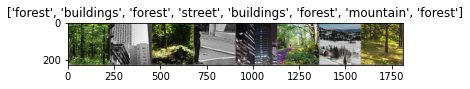

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# (Maximum) Number of images to show (to avoid too small images)
if len(inputs)>10:
    nImagesToShow = 8
else:
    nImagesToShow = len(inputs)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:nImagesToShow])

imshow(out, title=[class_names[x] for x in classes[:nImagesToShow]])

Training phase of the model
---------------------------

A general function to train a model.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, csvAccName="", csvLossName=""):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_best_model = 0
    
    # Variables in which metrics are saved, for each epoch
    train_loss = []; train_accuracy = []; test_loss = []; test_accuracy = []
    test_precision = []; test_recall = []; test_f1score = []; test_conf_matrix = [];
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Save losses and accuracies
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc.to('cpu').numpy())
            else: # phase == 'test'
                test_loss.append(epoch_loss)
                test_accuracy.append(epoch_acc.to('cpu').numpy())
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                epoch_best_model = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save and mark best model
                # COMMENT THE FOLLOWING LINE IF YOU DON'T WANT TO SAVE THE (BEST) MODEL
                torch.save(model.state_dict(), os.path.join(savingMetricsPath, "vgg16_best"+actualParams+".pth"))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, reached in epoch: {:d}/{:d}'.format(best_acc,epoch_best_model,num_epochs))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    #Save train losses and accuracies
    df_acc = pd.DataFrame(list(zip(train_accuracy, test_accuracy)), columns =['Train Accuracy', 'Test Accuracy'])
    df_loss = pd.DataFrame(list(zip(train_loss, test_loss)), columns =['Train Loss', 'Test Loss'])

    #Save test losses and accuracies
    df_acc.to_csv(os.path.join(csvLogs_path,csvAccName+".csv"), index=False)
    df_loss.to_csv(os.path.join(csvLogs_path,csvLossName+".csv"), index=False)
    print("""\n\nAll train/test accuracies and losses have been written on the .csv
        files in folder: """+str(csvLogs_path))
    
    return model # model with the best accuracy

Visualizing the model predictions
---------------------------------
Generic function to display predictions for a few images

`visualize_model(model, num_images=6)`




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet definition
------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model = models.vgg16(pretrained=True)
# Modify the output layer, to adapt it to our classification problem
model.classifier[6] = nn.Linear(4096, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=moment)

# Set learning_rate decay ######################################################
# Decay LR by a factor of "lr_dec_gamma" every "lr_dec_step_size" epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_dec_step_size, gamma=lr_dec_gamma)
################################################################################

Train and evaluate
------------------




In [ ]:
model_best = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=nEpochs, csvAccName="train_test_accuracy", csvLossName="train_test_loss")

Epoch 0/29
----------
train Loss: 1.7746 Acc: 0.2000
test Loss: 1.6965 Acc: 0.2667

Epoch 1/29
----------
train Loss: 1.6695 Acc: 0.3250
test Loss: 1.5496 Acc: 0.5533

Epoch 2/29
----------
train Loss: 1.5262 Acc: 0.4167
test Loss: 1.3940 Acc: 0.7089

Epoch 3/29
----------
train Loss: 1.3748 Acc: 0.5683
test Loss: 1.2336 Acc: 0.7578

Epoch 4/29
----------
train Loss: 1.2247 Acc: 0.6583
test Loss: 1.0671 Acc: 0.7900

Epoch 5/29
----------
train Loss: 1.0587 Acc: 0.7233
test Loss: 0.8994 Acc: 0.8067

Epoch 6/29
----------
train Loss: 0.9331 Acc: 0.7300
test Loss: 0.7448 Acc: 0.8367

Epoch 7/29
----------
train Loss: 0.8422 Acc: 0.7600
test Loss: 0.7305 Acc: 0.8400

Epoch 8/29
----------
train Loss: 0.8116 Acc: 0.7667
test Loss: 0.7169 Acc: 0.8389

Epoch 9/29
----------
train Loss: 0.7997 Acc: 0.7533
test Loss: 0.7039 Acc: 0.8411

Epoch 10/29
----------
train Loss: 0.7789 Acc: 0.7750
test Loss: 0.6911 Acc: 0.8422

Epoch 11/29
----------
train Loss: 0.8023 Acc: 0.7450
test Loss: 0.6789 Acc

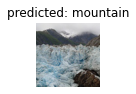

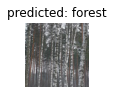

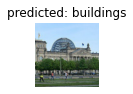

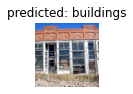

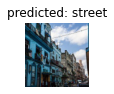

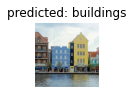

In [ ]:
visualize_model(model_best)

# Function to plot accuracies vs losses during the training

<Figure size 432x288 with 0 Axes>

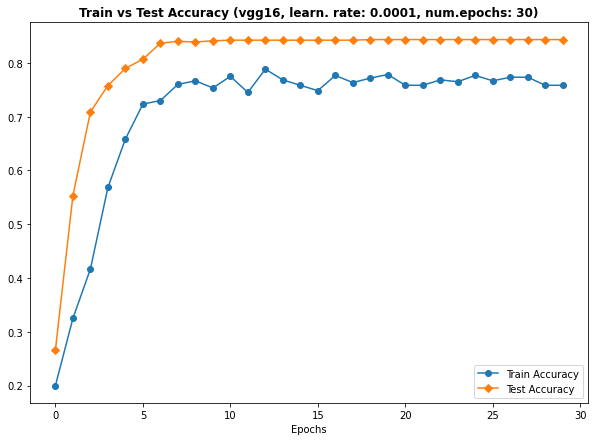

<Figure size 432x288 with 0 Axes>

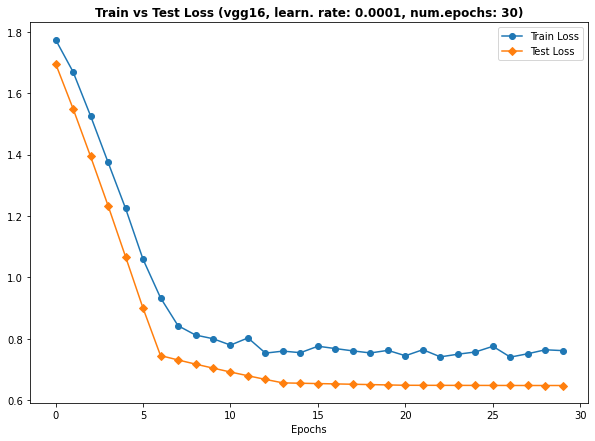

In [ ]:
def plot_acc_loss_trends(csv_acc_path, csv_loss_path):
    df_loss = pd.read_csv(csv_loss_path)
    df_accuracy = pd.read_csv(csv_acc_path)

    plt.figure(); ax = df_accuracy.plot(figsize=(10, 7));
    plt.title("Train vs Test Accuracy (vgg16, learn. rate: "+str(learning_rate)+", num.epochs: "+str(nEpochs)+")", fontweight='bold')
    markers = ['o','D']
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i])
        plt.legend(loc='best')
    plt.xlabel('Epochs')
    # Save this figure
    plt.savefig(savingMetricsPath+"/train_vs_test_ACC"+actualParams+".png", dpi=300)

    plt.figure(); ax = df_loss.plot(figsize=(10, 7));
    plt.title("Train vs Test Loss (vgg16, learn. rate: "+str(learning_rate)+", num.epochs: "+str(nEpochs)+")", fontweight='bold')
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i])
        plt.legend(loc='best')
    plt.xlabel('Epochs')
    # Save this figure
    plt.savefig(savingMetricsPath+"/train_vs_test_LOSS"+actualParams+".png", dpi=300)

plot_acc_loss_trends(csv_acc_path, csv_loss_path)

# Confusion Matrix computation

# Function to compute, plot and save the confusion matrix
**plot_confusion_matrix**(y_true, y_pred, classes,
normalize=False,title=None,cmap= 'viridis',saving_path=None)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap= 'viridis',
                          saving_path=None):
    """
    This function plots and returns the confusion matrix.
    It also returns the figure handler, as second output.
    Normalization (rows) can be applied by setting `normalize=True`.
    cmap choices: 'plt.cm.Blues', 'inferno', 'viridis', 'cividis'
    """
    
    conf_matrix = confusion_matrix(y_true, y_pred) # Compute confusion matrix
   
    # Normalization along rows
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.rc('font', size=21)
    plt.rc('xtick', labelsize=21)
    plt.rc('ytick', labelsize=21)
    plt.title(title)
    disp.plot(ax=ax, cmap=cmap, xticks_rotation=45)
    fig.tight_layout()
    
    return [conf_matrix, fig]

# Function to compute metrics values
for a given model evaluated on a specific dataloader:

**compute_metrics**(model, dataloader, device, save=True)

In [ ]:
def compute_metrics(model, dataloader, device, save=True):

    # Initialize the prediction and label lists(tensors)
    predictions_list = torch.zeros(0, dtype=torch.long, device='cpu')
    labels_list = torch.zeros(0, dtype=torch.long, device='cpu')

    # Disabling gradient calculation, useful to reduce memory consumption for
    # computations that would otherwise have requires_grad=True
    with torch.no_grad():
        print("Computing model predictions...")
        for i, (inputs, classes) in enumerate(dataloader):
            print("Batch n. {:d}/{:d}...".format(i+1,len(dataloader)),end="")
            since = time.time()
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs) # compute probabilities about "inputs" images batch, of belonging to each class
            _, preds = torch.max(outputs, 1) # preds -> class (indeces) with the hghest value (for the single image)
            # preds: index of the maximum element inside outputs tensor

            # Append batch prediction results
            predictions_list = torch.cat([predictions_list, preds.view(-1).cpu()])
            labels_list = torch.cat([labels_list, classes.view(-1).cpu()])
            # .view(-1) reshape to row vector
            time_elapsed = time.time() - since
            print("({:.0f}m {:.0f}s)".format(time_elapsed // 60, time_elapsed % 60))

    # Clear outputs
    clear_output(wait=True)

    true_labels = labels_list.numpy()
    pred_labels = predictions_list.numpy()

    print("Computing metrics on true/predicted labels...",end="")
    # Accuracy, Precision, Recall and Confusion Matrix for the model
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1score = f1_score(true_labels, pred_labels, average='macro')
    class_report = classification_report(true_labels, pred_labels)
    conf_mat, fig = plot_confusion_matrix(true_labels, pred_labels,
        classes=class_names,
        title='vgg16, learning rate: '+str(learning_rate)+', num. epochs: '+str(nEpochs))

    classes_accuracy = conf_mat.diagonal()/conf_mat.sum(1)
    print("END")
    # Per-class accuracy
    i = 0
    str_acc_per_class = "Per-class accuracy:\n"
    for class_name in class_names:
        str_acc_per_class = str_acc_per_class +"{:s}: {:.2f} %".format(class_name, 100*classes_accuracy[i])+" | "
        i += 1
    #print(str_acc_per_class,end="\n\n")

    metrics_str = """VGG16: all layers trained
----------------------------------------------------------------------------
learning rate={:f}, num. epochs={:d}, momentum={:f}
Learning rate decay: step size={:d}, gamma={:f}
----------------------------------------------------------------------------
accuracy = {:f}, precision = {:f}, recall = {:f}, f1-score = {:f}""".format(\
        learning_rate,nEpochs,moment,lr_dec_step_size,lr_dec_gamma,\
        acc, prec, recall, f1score)
    
    metrics_str = metrics_str + "\n\n" + str_acc_per_class
    metrics_str = metrics_str + "\n\n" + "Classification report:\n\n" + class_report

    print(metrics_str)
    print("\n\n")

    metrics_csv = """learning rate;nEpochs;accuracy;precision;recall;f1-score\n{:f};{:f};{:f};{:f};{:f};{:f}""".format(learning_rate,nEpochs,acc, prec, recall, f1score)

    if save:
        # Save "metrics_str" to file
        file_path = savingMetricsPath+"/metrics"+actualParams+".txt"
        text_file = open(file_path, "w")
        text_file.write(metrics_str)
        text_file.close()
        print("SAVED: ", file_path)

        # Save metrics as a "csv" ordered file
        file_path = savingMetricsPath+"/metrics"+actualParams+".csv"
        text_file = open(file_path, "w")
        text_file.write(metrics_csv)
        text_file.close()
        print("SAVED: ", file_path)

        # Save confusion matrix
        #fig.tight_layout()
        fig.savefig(savingMetricsPath+"/conf_matrix"+actualParams+".png", dpi=fig.dpi)
        print("SAVED: ", savingMetricsPath+"/conf_matrix"+actualParams+".jpg")

# Final **TEST** phase: metrics computation

Entire test dataset loading

In [ ]:
final_test_data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

final_test_image_datasets = datasets.ImageFolder(finalTestPath, final_test_data_transforms['test'])

if str(device)=='cpu':
    batch_size = 200
else:
    batch_size = 128
print("Batch size: ", batch_size)

finaltestdataloaders = torch.utils.data.DataLoader(final_test_image_datasets, batch_size=batch_size,
                                             shuffle=True)
class_names = final_test_image_datasets.classes

print("Device: ", device)
print("Number of images in the entire 'test' dataset: " + str(len(final_test_image_datasets)))
print("Class names: " + str(class_names) )

Batch size:  128
Device:  cuda
Number of images in the entire 'test' dataset: 3000
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# Load best model

# Load an "empty" model
finalModel = models.vgg16()
finalModel.classifier[6] = nn.Linear(4096, len(class_names))
finalModel = finalModel.to(device)

# To specify manually the desired model
#learning_rate = 0.01
#actualParams = "_LR("+str(learning_rate).replace(".","_")+")_nEpochs(" + str(nEpochs) + ")"
# Until here ==========================
model_best_path = savingMetricsPath+"/vgg16_best"+actualParams+".pth"
print("Best model path: ", model_best_path)
print("Exists? ", os.path.exists(model_best_path))

# Overwrite the "empty" model with the trained one (its dictionary)
finalModel.load_state_dict(torch.load(model_best_path, map_location=torch.device(device.type)))
finalModel.eval();

Best model path:  gdrive/MyDrive/ML_AI/CNN_finalMetrics/vgg/vgg16_LR(0_01)_nEpochs(30)/vgg16_best_LR(0_01)_nEpochs(30).pth
Exists?  True


Computing metrics on true/predicted labels...END
VGG16: all layers trained
----------------------------------------------------------------------------
learning rate=0.010000, num. epochs=30, momentum=0.900000
Learning rate decay: step size=7, gamma=0.100000
----------------------------------------------------------------------------
accuracy = 0.864000, precision = 0.870100, recall = 0.865060, f1-score = 0.866428

Per-class accuracy:
buildings: 81.92 % | forest: 97.05 % | glacier: 84.45 % | mountain: 78.10 % | sea: 84.51 % | street: 93.01 % | 

Classification report:

              precision    recall  f1-score   support

           0       0.92      0.82      0.86       437
           1       0.98      0.97      0.97       474
           2       0.78      0.84      0.81       553
           3       0.83      0.78      0.80       525
           4       0.87      0.85      0.86       510
           5       0.85      0.93      0.89       501

    accuracy                           0.86 

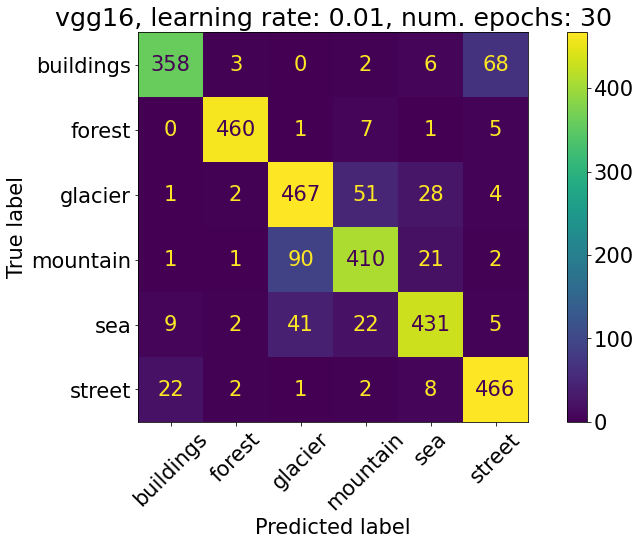

In [ ]:
# Compute metrics related to the previously loaded best model,
# evaluating it on the entire test set
compute_metrics(finalModel, finaltestdataloaders, device, save=True)

# Plot accuracy, precision, recall, f1-score AGAINST learning rate


In [ ]:
#@title Function definition: create_4bars_chart() (to plot metrics comparisons of different models)
def create_4bars_chart(rangeX, dataY_1, dataY_2, dataY_3, dataY_4, labelsY, title, plotLabelX, plotLabelY):

    savingPath = ""
    barWidth = 0.2
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set position of bar on X axis
    br1 = np.arange(len(dataY_1))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    # Make the plot
    plt.bar(br1, dataY_1, color=(0.533, 0.67, 0.81), width=barWidth, edgecolor='grey', label=labelsY[0])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br1:
        plt.text(x_loc - 0.06, dataY_1[i], "{:.2f}".format(dataY_1[i]), fontsize=16); i = i + 1
    plt.bar(br2, dataY_2, color=(0.95, 0.627, 0.34), width=barWidth, edgecolor='grey', label=labelsY[1])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br2:
        plt.text(x_loc - 0.06, dataY_2[i], "{:.2f}".format(dataY_2[i]), fontsize=16); i = i + 1
    plt.bar(br3, dataY_3, color=(0.525, 0.7, 0.498), width=barWidth, edgecolor='grey', label=labelsY[2])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br3:
        plt.text(x_loc - 0.06, dataY_3[i], "{:.2f}".format(dataY_3[i]), fontsize=16); i = i + 1
    plt.bar(br4, dataY_4, color=(0.847, 0.562, 0.9), width=barWidth, edgecolor='grey', label=labelsY[3])
    ax.tick_params(axis='x', labelsize=18)
    i = 0
    for x_loc in br4:
        plt.text(x_loc - 0.06, dataY_4[i], "{:.2f}".format(dataY_4[i]), fontsize=16); i = i + 1

    # ---- added for the legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08),
              ncol=4, fancybox=True, shadow=True, prop={"size":17})
    plt.title(title, fontweight='bold', fontsize=18, y=1.06)
    # -----

    plt.ylabel(plotLabelY, fontweight='bold', fontsize=18)
    plt.xlabel(plotLabelX, fontweight='bold', fontsize=18)
    plt.xticks([r + barWidth+0.1 for r in range(len(dataY_1))], rangeX)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)

    
    plt.tight_layout()

    return fig, ax


Show and save histogram of metrics comparisons

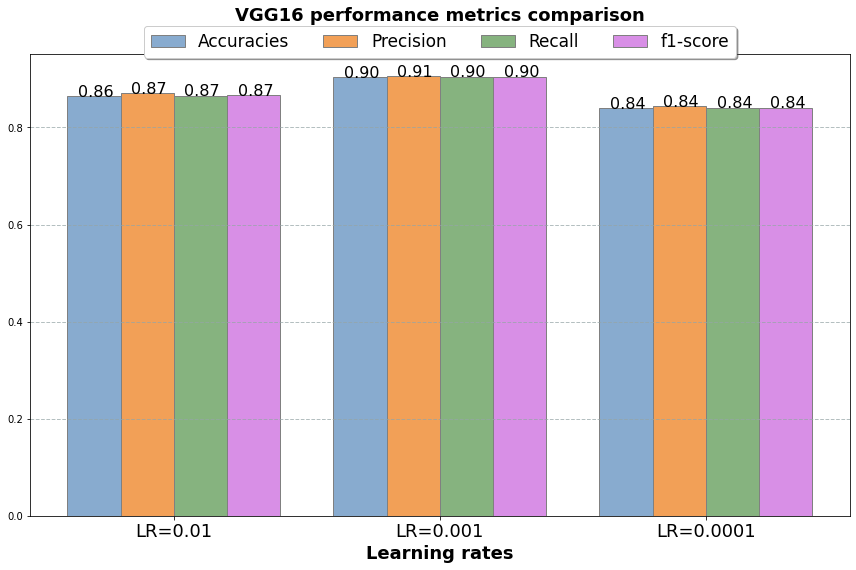

In [ ]:
# Load the histogram plot of accuracy, recall, precision, f1-score
import pandas as pd

csv1_path = gdrivePath + "/CNN_finalMetrics/vgg" + "/vgg16_LR(0_01)_nEpochs(30)/metrics_LR(0_01)_nEpochs(30).csv"
csv2_path = gdrivePath + "/CNN_finalMetrics/vgg" + "/vgg16_LR(0_001)_nEpochs(30)/metrics_LR(0_001)_nEpochs(30).csv"
csv3_path = gdrivePath + "/CNN_finalMetrics/vgg" + "/vgg16_LR(0_0001)_nEpochs(30)/metrics_LR(0_0001)_nEpochs(30).csv"

csv1 = pd.read_csv(csv1_path, sep=';', engine='python')
csv2 = pd.read_csv(csv2_path, sep=';', engine='python')
csv3 = pd.read_csv(csv3_path, sep=';', engine='python')

barLabels = ["LR="+str(csv1['learning rate'].values[0]),"LR="+str(csv2['learning rate'].values[0]), \
             "LR="+str(csv3['learning rate'].values[0])]
accuracies = [csv1['accuracy'].values[0], csv2['accuracy'].values[0], csv3['accuracy'].values[0]]
precisions = [csv1['precision'].values[0], csv2['precision'].values[0], csv3['precision'].values[0]]
recalls = [csv1['recall'].values[0], csv2['recall'].values[0], csv3['recall'].values[0]]
f1scores = [csv1['f1-score'].values[0], csv2['f1-score'].values[0], csv3['f1-score'].values[0]]

[fig, ax] = create_4bars_chart(barLabels, dataY_1=accuracies, dataY_2=precisions,
              dataY_3=recalls, dataY_4=f1scores,
              labelsY=["Accuracies", "Precision", "Recall", "f1-score"],
              title="VGG16 performance metrics comparison", plotLabelX="Learning rates", plotLabelY="")

# Save the histogram plot
folder_path = savingMetricsPath+"/.."
file_name = os.path.join( folder_path, "performancesHistogram_differentLR.jpg" )
fig.savefig(file_name, dpi=fig.dpi)
